# Brain Volume Analysis

In [1]:
import graspologic as gp
import hyppo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import squareform
from statsmodels.stats.multitest import multipletests

from pkg.data import (
    GENOTYPES,
    HEMISPHERES,
    SUPER_STRUCTURES,
    load_vertex_metadata,
    load_volume,
)

In [2]:
## Read the data
data, labels = load_volume()
vertex_name, vertex_hemispheres, vertex_structures = load_vertex_metadata()

print(data.shape)
print(labels.shape)

(29, 332)
(29,)


## Testing whether group volumes are significantly different

We compute 3-sample distance correlation to see if there is any differences in the 3 groups. Specifically, we test whether the distribution of brain volumes from at least two genotypes are different.

In [3]:
ksample = hyppo.ksample.KSample("dcorr")

brain_volumes = [data[labels == genotype] for genotype in GENOTYPES]

stat, pval = ksample.test(*brain_volumes)

print(pval)

0.006007509501547217


We see significant difference among the three genotypes

## Finding Signal Communities

We stratify by hemisphere, super structure, then hemisphere + super structure

### Testing for significant hemispheres

In [6]:
hemisphere_volumes = []

for hemisphere in HEMISPHERES:
    to_append = [
        brain_volumes[idx][:, vertex_hemispheres == hemisphere]
        for idx in range(len(GENOTYPES))
    ]
    hemisphere_volumes.append(to_append)

In [7]:
# Run Dcorr
stats, pvals = [], []

for idx in range(len(hemisphere_volumes)):
    to_test = hemisphere_volumes[idx]
    stat, pval = ksample.test(*to_test)

    stats.append(stat)
    pvals.append(pval)

significant, corrected_pvals, _, corrected_alpha = multipletests(pvals, method="holm")

print(corrected_pvals)

[0.01730104 0.00929847]


### Testing for significant super structures

In [8]:
structure_volumes = []

for structure in SUPER_STRUCTURES:
    to_append = [
        brain_volumes[idx][:, vertex_structures == structure]
        for idx in range(len(GENOTYPES))
    ]
    structure_volumes.append(to_append)

In [9]:
# Run Dcorr
stats, pvals = [], []

for idx in range(len(structure_volumes)):
    to_test = structure_volumes[idx]
    stat, pval = ksample.test(*to_test)

    stats.append(stat)
    pvals.append(pval)

significant, corrected_pvals, _, corrected_alpha = multipletests(pvals, method="holm")

print(corrected_pvals)

[0.04506916 0.01793374 0.01793374 0.04506916 0.83478065]


### Testing for significant regions

In [11]:
# Run Dcorr
stats, pvals = [], []

ksample = hyppo.ksample.KSample("dcorr")

for idx in range(vertex_name.size):
    to_test = [brain_volumes[jdx][:, idx : idx + 1] for jdx in range(len(GENOTYPES))]
    stat, pval = ksample.test(
        *to_test,
    )

    stats.append(stat)
    pvals.append(pval)

significant, corrected_pvals, _, corrected_alpha = multipletests(pvals, method="holm")

print(pvals)

[0.20667033191212072, 0.15345316032851392, 0.03752993218026134, 0.5598786954281109, 0.09909753512313449, 0.13862172536721365, 0.03378263356723513, 0.1806511209061934, 0.2763029248993436, 0.30243435490514975, 0.20797274107173208, 1.0, 0.15874611345079176, 0.06326727945032981, 0.556399229935349, 0.06597039662124302, 0.5681540220660034, 0.10317860617489735, 1.0, 1.0, 1.0, 0.11446313495201856, 0.4016062224632988, 0.1330282755872462, 0.015464136530246194, 1.0, 0.10437533411063316, 0.04545181749070466, 0.371086742250629, 1.0, 0.07725279814889259, 1.0, 0.18684477716938608, 1.0, 0.01636552944013374, 0.006725989898696442, 0.09568546002414563, 0.24484180543103667, 0.04668008174709784, 0.11185340466084681, 1.0, 0.20798695390136204, 0.5914082687124695, 1.0, 0.265863127850386, 1.0, 0.23972671739555745, 0.019845608422675232, 1.0, 0.06161852150555486, 0.00845363473503148, 0.0007632568215107018, 0.36584042365549496, 0.04843295600209349, 0.48469340976280684, 0.3129821599355795, 0.07527576763791287, 1.0

In [15]:
0.05 / 332

0.00015060240963855423

## Testing for differences in the brain volume covariance

Using similar procedure as above, we test whether the covariances are different among the genotypes. Prior to the 3-sample test, we use Omnibus embedding on the covariance matrices to obtain latent positions, which we then test for difference in distributions.

In [7]:
omni = gp.embed.OmnibusEmbed()

omni.fit([dat for (_, dat) in cor_dat.items()])

Xhats = omni.latent_left_
print(Xhats.shape)

(3, 332, 4)


In [8]:
ksample = hyppo.ksample.KSample("dcorr")

_, pval = ksample.test(*Xhats)

print(pval)

8.254124554923335e-26


We again see a significant difference in distributions

## Testing for differences in pairwise covariances

We then test for whether the distribution of each pair of genotypes are different.

In [9]:
genotypes = ["APOE22", "APOE33", "APOE44"]

ksample = hyppo.ksample.KSample("dcorr")


res = []

for i, g in enumerate(genotypes):
    for j, h in enumerate(genotypes):
        if g == h:
            res.append([g, h, 1])
        else:
            _, pval = ksample.test(Xhats[i], Xhats[j])
            res.append([g, h, pval])

In [10]:
pairwise_df = pd.DataFrame(res, columns=["Genotype 1", "Genotype 2", "pvalue"])

In [11]:
pairwise_df["Genotype 1"] = pairwise_df["Genotype 1"].astype("category")
pairwise_df["Genotype 2"] = pairwise_df["Genotype 2"].astype("category")
pairwise_df["log(pvalue)"] = np.log(pairwise_df["pvalue"])

In [12]:
pairwise_df

,Genotype 1,Genotype 2,pvalue,log(pvalue)
0,APOE22,APOE22,1.000000e+00,0.000000
1,APOE22,APOE33,9.932969e-21,-46.058427
2,APOE22,APOE44,1.014474e-17,-39.129576
3,APOE33,APOE22,9.932969e-21,-46.058427
4,APOE33,APOE33,1.000000e+00,0.000000
5,APOE33,APOE44,3.573940e-16,-35.567693
6,APOE44,APOE22,1.014474e-17,-39.129576
7,APOE44,APOE33,3.573940e-16,-35.567693
8,APOE44,APOE44,1.000000e+00,0.000000


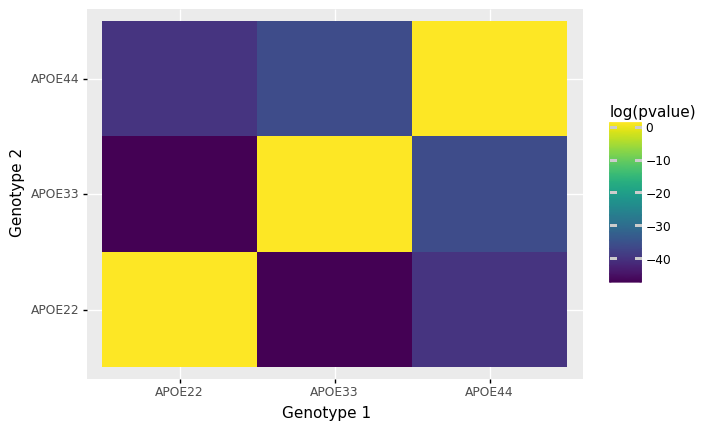

<ggplot: (8766045953917)>

In [13]:
plot = p9.ggplot(
    p9.aes(x="Genotype 1", y="Genotype 2", fill="log(pvalue)")
) + p9.geom_tile(pairwise_df)

plot